# Section - Listening

In [ ]:
!pip install tensorflow transformers scikit-learn

In [ ]:
import json
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras import regularizers

# Set seed
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Load data
with open('listening_new.json', 'r') as f:
    questions = json.load(f)

# Simulasi user
data = []
n_users_per_label = 50

for label in ['Short Conversation', 'Extended Conversation', 'Talk']:
    for _ in range(n_users_per_label):
        user_results = []
        error_probs = {
            'Short Conversation': np.random.uniform(0.1, 0.2),
            'Extended Conversation': np.random.uniform(0.1, 0.2),
            'Talk': np.random.uniform(0.1, 0.2),
        }
        error_probs[label] = np.random.uniform(0.6, 0.8)

        for q in questions:
            part = q['part']
            correct = np.random.rand() > error_probs[part]
            user_results.append((part, correct))

        stats = {}
        for part in ['Short Conversation', 'Extended Conversation', 'Talk']:
            part_results = [r for r in user_results if r[0] == part]
            total = len(part_results)
            wrong = sum(not r[1] for r in part_results)
            stats[f"{part}_err"] = wrong / total if total > 0 else 0

        weak_part = max(stats, key=stats.get).replace('_err', '')
        data.append({
            'short_err': stats['Short Conversation_err'],
            'extended_err': stats['Extended Conversation_err'],
            'talk_err': stats['Talk_err'],
            'weak_part': weak_part
        })

# DataFrame dan fitur
df = pd.DataFrame(data)
df['short_vs_ext'] = df['short_err'] - df['extended_err']
df['short_vs_talk'] = df['short_err'] - df['talk_err']
df['ext_vs_talk'] = df['extended_err'] - df['talk_err']

X = df[['short_err', 'extended_err', 'talk_err', 'short_vs_ext', 'short_vs_talk', 'ext_vs_talk']].values
le = LabelEncoder()
y_int = le.fit_transform(df['weak_part'])
y = tf.keras.utils.to_categorical(y_int, num_classes=3)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y_int, random_state=SEED
)

# Arsitektur model sederhana dengan regularisasi
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(6,)),
    tf.keras.layers.Dense(24, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(12, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callback untuk EarlyStopping dan learning rate decay
# Callback khusus: stop ketika val_accuracy >= 0.85
class CustomEarlyStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')
        if val_acc is not None and val_acc >= 0.85:
            print(f"\n✅ Validation accuracy {val_acc:.2f} >= 0.85. Stopping training.")
            self.model.stop_training = True

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1
    ),
    CustomEarlyStopping()  # Tambahkan di sini
]


# Training
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=8,
    callbacks=callbacks,
    verbose=1
)

# Evaluasi
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n🎯 Test Accuracy: {acc:.2f}")

# Prediksi
y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

# Report
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.1013 - loss: 1.1573 - val_accuracy: 0.0000e+00 - val_loss: 1.1142 - learning_rate: 0.0010
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1506 - loss: 1.1191 - val_accuracy: 0.2083 - val_loss: 1.0749 - learning_rate: 0.0010
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2600 - loss: 1.0780 - val_accuracy: 0.7083 - val_loss: 1.0280 - learning_rate: 0.0010
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5096 - loss: 1.0335 - val_accuracy: 0.7500 - val_loss: 0.9689 - learning_rate: 0.0010
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6270 - loss: 0.9770 - val_accuracy: 0.7500 - val_loss: 0.8958 - learning_rate: 0.0010
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6599 - loss: 0.9133 - val_accuracy: 0.7500 - val_loss: 0.8120 - learning_rate: 0.0010
Epoch 7/50
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6250 - loss: 0.7903
✅ Validati

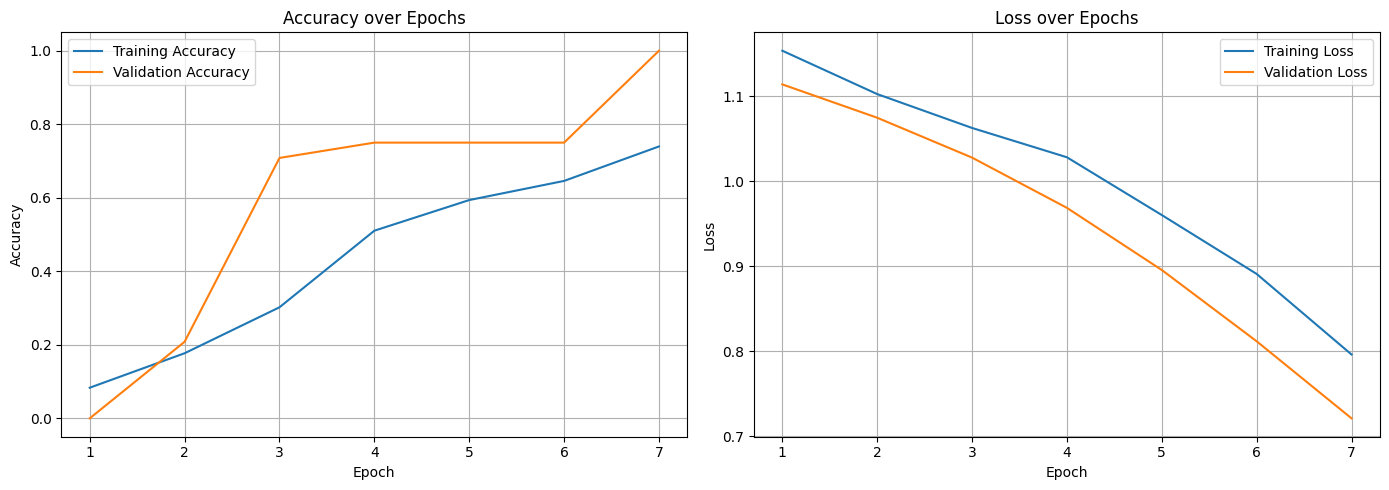

In [ ]:
import matplotlib.pyplot as plt

# Visualisasi hasil evaluasi model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# 12. Simpan model dan label encoder
model.save('weak_part_classifier.h5')
import joblib
joblib.dump(le, 'label_encoder.pkl')


['label_encoder.pkl']

In [ ]:
import numpy as np
import tensorflow as tf
import joblib

# Load model dan label encoder
model = tf.keras.models.load_model('weak_part_classifier.h5')
le = joblib.load('label_encoder.pkl')

# Contoh error rate user
short, ext, talk = 0.1, 0.1, 0.8
features = np.array([[short, ext, talk,
                      short - ext, short - talk, ext - talk]])

# Prediksi
pred = model.predict(features)
pred_probs = pred[0]
label_index = np.argmax(pred_probs)
pred_label = le.inverse_transform([label_index])[0]

# Output
print(f"\n✅ Prediksi kelemahan user: {pred_label}")
print(f"📊 Probabilitas prediksi: {pred_probs}")
print(f"🏷️ Label indeks: {label_index}, Label kelas: {le.classes_[label_index]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step

✅ Prediksi kelemahan user: Talk
📊 Probabilitas prediksi: [0.395702   0.19924808 0.40504998]
🏷️ Label indeks: 2, Label kelas: Talk
